In [1]:
from numba import njit
import numpy as np
from skimage import io

array([[  4,   7,   6, ..., 112, 108, 110],
       [  6,   8,   7, ..., 110, 109, 110],
       [  5,   4,   5, ..., 108, 110, 108],
       ...,
       [  6,   6,   5, ...,  33,  30,  31],
       [  7,   4,   4, ...,  33,  34,  36],
       [  8,   4,   3, ...,  37,  39,  27]], dtype=uint8)

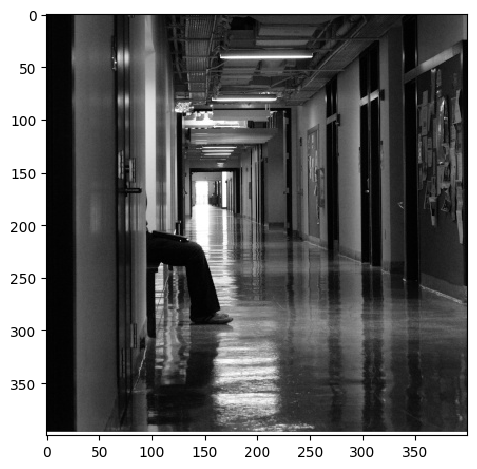

In [2]:
image = io.imread('../book/images/hallway.jpg')
image_large = io.imread('../book/images/hallway_large.jpg')
display(image_large)
io.imshow(image)

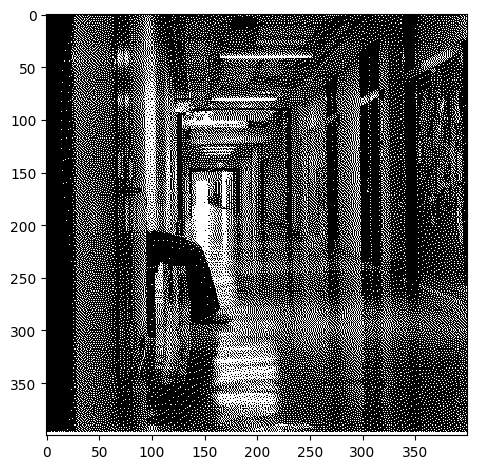

In [4]:
@njit
def dither(img):
    # Allow negative values and wider range:
    result = img.astype(np.int16)  
    for y in range(img.shape[0]):
        for x in range(img.shape[1]):
            old_value = result[y, x]
            if old_value < 0:
                new_value = 0
            elif old_value > 255:
                new_value = 255
            else:
                new_value = np.uint8(np.round(old_value / 255.0)) * 255
            result[y, x] = new_value
            error = np.int16(old_value) - new_value  # might get negative value
            if x < img.shape[1] - 1:
                result[y, x + 1] += error * 7 // 16
            if y < img.shape[0] - 1 and x > 0:
                result[y + 1, x - 1] += error * 3 // 16
            if y < img.shape[0] - 1:
                result[y + 1, x] += error * 5 // 16
            if y < img.shape[0] - 1 and x < img.shape[1] - 1:
                result[y + 1, x + 1] += error // 16
    return result.astype(np.uint8)

io.imshow(dither(image))

In [5]:
%timeit dither(image)
%timeit dither(image_large)

2.34 ms ± 1.95 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
59.6 ms ± 96.2 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


2.33 ms ± 806 ns per loop (mean ± std. dev. of 7 runs, 100 loops each)
59.4 ms ± 26.3 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


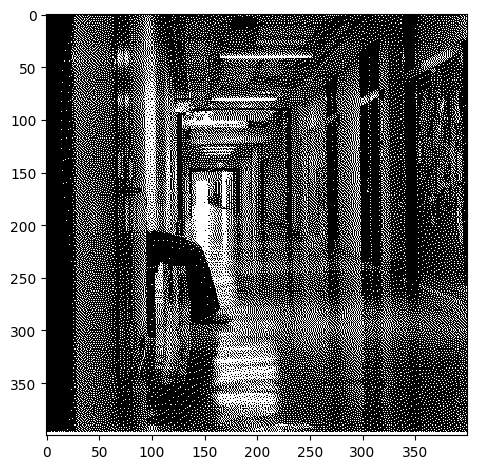

In [5]:
# Use better constant names
from numpy import float32

@njit
def dither2(img):
    # Allow negative values and wider range:
    result = img.astype(np.int16)
    y_size = img.shape[0]
    x_size = img.shape[1]
    last_y = y_size - 1
    last_x = x_size - 1
    for y in range(y_size):
        for x in range(x_size):
            old_value = result[y, x]
            if old_value < 0:
                new_value = 0
            elif old_value > 255:
                new_value = 255
            else:
                new_value = np.uint8(np.round(old_value / 255.0)) * 255
            result[y, x] = new_value
            error = np.int16(old_value) - new_value  # might get negative value
            if x < last_x:
                result[y, x + 1] += error * 7 // 16
            if y < last_y and x > 0:
                result[y + 1, x - 1] += error * 3 // 16
            if y < last_y:
                result[y + 1, x] += error * 5 // 16
            if y < last_y and x < last_x:
                result[y + 1, x + 1] += error // 16
    return result.astype(np.uint8)

io.imshow(dither2(image))
%timeit dither2(image)
%timeit dither2(image_large)

2.21 ms ± 599 ns per loop (mean ± std. dev. of 7 runs, 100 loops each)
56.1 ms ± 40.4 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


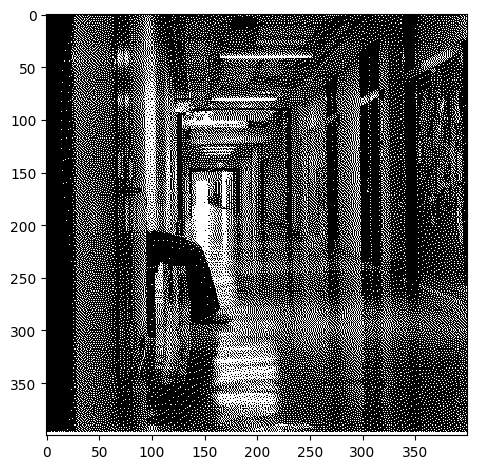

In [6]:
# Switch to float32 instead of float64
from numpy import float32

@njit
def dither3(img):
    # Allow negative values and wider range:
    result = img.astype(np.int16)
    y_size = img.shape[0]
    x_size = img.shape[1]
    last_y = y_size - 1
    last_x = x_size - 1
    for y in range(y_size):
        for x in range(x_size):
            old_value = result[y, x]
            if old_value < 0:
                new_value = 0
            elif old_value > 255:
                new_value = 255
            else:
                new_value = np.uint8(np.round(old_value / float32(255.0))) * 255
            result[y, x] = new_value
            error = np.int16(old_value) - new_value  # might get negative value
            if x < last_x:
                result[y, x + 1] += error * 7 // 16
            if y < last_y and x > 0:
                result[y + 1, x - 1] += error * 3 // 16
            if y < last_y:
                result[y + 1, x] += error * 5 // 16
            if y < last_y and x < last_x:
                result[y + 1, x + 1] += error // 16
    return result.astype(np.uint8)

io.imshow(dither3(image))
%timeit dither3(image)
%timeit dither3(image_large)

2.64 ms ± 1.5 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
66.7 ms ± 34.8 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


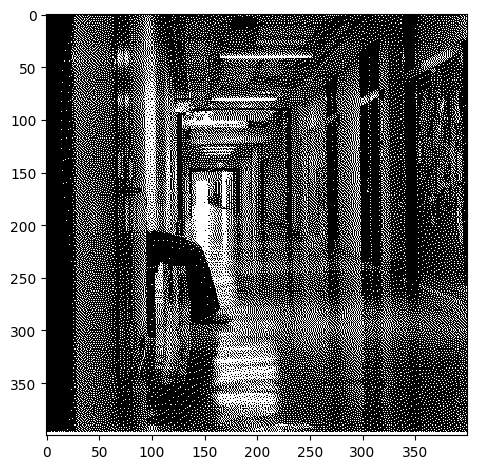

In [7]:
# Start reducing conditionals:
from numpy import float32

@njit
def dither4(img):
    # Allow negative values and wider range:
    result = img.astype(np.int16)
    y_size = img.shape[0]
    x_size = img.shape[1]
    last_y = y_size - 1
    last_x = x_size - 1
    for y in range(y_size):
        for x in range(x_size):
            old_value = result[y, x]
            new_value = 0 if old_value < 0 else (255 if old_value > 255 else old_value)
            new_value = np.uint8(np.round(new_value / float32(255.0))) * 255
            result[y, x] = new_value
            error = np.int16(old_value) - new_value  # might get negative value
            if x < last_x:
                result[y, x + 1] += error * 7 // 16
            if y < last_y and x > 0:
                result[y + 1, x - 1] += error * 3 // 16
            if y < last_y:
                result[y + 1, x] += error * 5 // 16
            if y < last_y and x < last_x:
                result[y + 1, x + 1] += error // 16
    return result.astype(np.uint8)

io.imshow(dither4(image))
%timeit dither4(image)
%timeit dither4(image_large)

827 µs ± 4.54 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)
21.1 ms ± 106 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


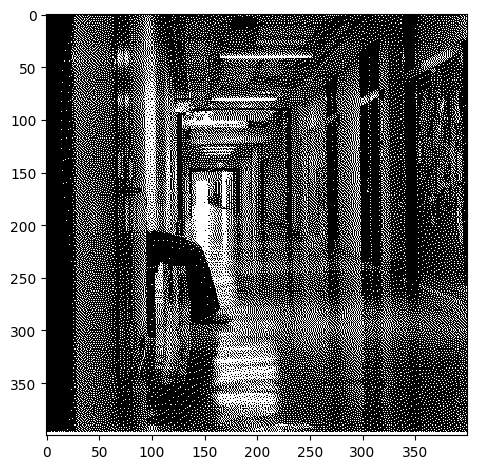

In [8]:
# Switch to float32 instead of float64
from numpy import float32

@njit
def dither5(img):
    # Allow negative values and wider range:
    result = img.astype(np.int16)
    y_size = img.shape[0]
    x_size = img.shape[1]
    last_y = y_size - 1
    last_x = x_size - 1
    for y in range(y_size):
        for x in range(x_size):
            old_value = result[y, x]
            new_value = 0 if old_value < 128 else 255
            result[y, x] = new_value
            error = old_value - new_value  # might get negative value
            if x < last_x:
                result[y, x + 1] += error * 7 // 16
            if y < last_y and x > 0:
                result[y + 1, x - 1] += error * 3 // 16
            if y < last_y:
                result[y + 1, x] += error * 5 // 16
            if y < last_y and x < last_x:
                result[y + 1, x + 1] += error // 16
    return result.astype(np.uint8)

io.imshow(dither5(image))
%timeit dither5(image)
%timeit dither5(image_large)

In [9]:
from subprocess import Popen
from contextlib import contextmanager
from os import getpid
from time import sleep
from signal import SIGINT

@contextmanager
def perf_stat():
    p = Popen(["perf", "stat", "-p", str(getpid())])
    sleep(0.5)
    yield
    p.send_signal(SIGINT)

In [10]:
with perf_stat():
    %timeit dither5(image)

823 µs ± 1.36 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)



 Performance counter stats for process id '248263':

          6,677.39 msec task-clock:u                     #    0.937 CPUs utilized             
                 0      context-switches:u               #    0.000 /sec                      
                 0      cpu-migrations:u                 #    0.000 /sec                      
                 0      page-faults:u                    #    0.000 /sec                      
    23,975,874,559      cpu_core/cycles/u                #    3.591 G/sec                       (99.95%)
    23,752,536,053      cpu_atom/cycles/u                #    3.557 G/sec                       (0.05%)
    78,645,069,533      cpu_core/instructions/u          #   11.778 G/sec                       (99.95%)
    62,917,471,673      cpu_atom/instructions/u          #    9.422 G/sec                       (0.05%)
     9,189,275,411      cpu_core/branches/u              #    1.376 G/sec                       (99.95%)
     7,763,064,744      cpu_atom/branches/u

909 µs ± 229 ns per loop (mean ± std. dev. of 7 runs, 1,000 loops each)
22.4 ms ± 19 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


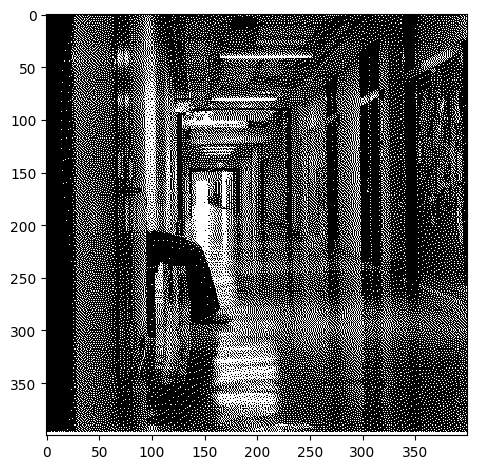

In [11]:
# Only need two rows at at a time for error accumulation
from numpy import float32

@njit
def dither6(img):
    result = np.empty(img.shape, dtype=np.uint8)
    # Allow negative values and wider range:
    staging = img[0:2].astype(np.int16)
    y_size = img.shape[0]
    x_size = img.shape[1]
    last_y = y_size - 1
    last_x = x_size - 1
    for y in range(y_size):
        for x in range(x_size):
            old_value = staging[0, x]
            new_value = 0 if old_value < 128 else 255
            staging[0, x] = new_value
            error = old_value - new_value  # might get negative value
            if x < last_x:
                staging[0, x + 1] += error * 7 // 16
            if x > 0:
                staging[1, x - 1] += error * 3 // 16
            staging[1, x] += error * 5 // 16
            if x < last_x:
                staging[1, x + 1] += error // 16

        # Copy current row of staging into result:
        result[y,:] = staging[0,:]
        # Prepare staging area for next iteration:
        staging[0,:] = staging[1,:]
        if y < y_size - 2:
            staging[1,:] = img[y + 2,:]
    return result

io.imshow(dither6(image))
%timeit dither6(image)
%timeit dither6(image_large)

876 µs ± 195 ns per loop (mean ± std. dev. of 7 runs, 1,000 loops each)
21.9 ms ± 34.4 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


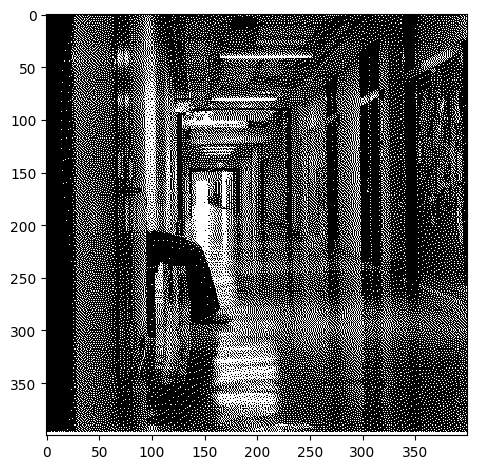

In [12]:
# Reduce unnecessary memory copying (which also invalidates cache)
from numpy import float32

@njit
def dither7(img):
    result = np.empty(img.shape, dtype=np.uint8)
    # Allow negative values and wider range:
    staging_current = img[0].astype(np.int16)
    staging_next = img[1].astype(np.int16)
    y_size = img.shape[0]
    x_size = img.shape[1]
    last_x = x_size - 1
    for y in range(y_size):
        for x in range(x_size):
            old_value = staging_current[x]
            new_value = 0 if old_value < 128 else 255
            staging_current[x] = new_value
            error = old_value - new_value  # might get negative value
            if x < last_x:
                staging_current[x + 1] += error * 7 // 16
            if x > 0:
                staging_next[x - 1] += error * 3 // 16
            staging_next[x] += error * 5 // 16
            if x < last_x:
                staging_next[x + 1] += error // 16

        # Copy current row of staging into result:
        result[y,:] = staging_current[:]
        # Switch current to next row, and copy in new next row data:
        staging_current, staging_next = staging_next, staging_current
        if y < y_size - 2:
            staging_next[:] = img[y + 2,:]
    return result

io.imshow(dither7(image))
%timeit dither7(image)
%timeit dither7(image_large)

855 µs ± 256 ns per loop (mean ± std. dev. of 7 runs, 1,000 loops each)
21.3 ms ± 26.9 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


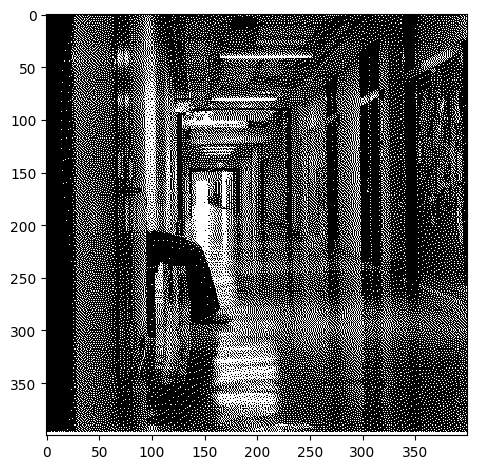

In [13]:
# Reduce unnecessary memory copying (which also invalidates cache)
from numpy import float32

@njit
def dither8(img):
    result = np.empty(img.shape, dtype=np.uint8)
    y_size = img.shape[0]
    x_size = img.shape[1]
    # Allow negative values and wider range; also, the staging arrays have extra entry at start and end
    # so we don't need conditionals in the core loop.
    staging_current = np.zeros(x_size + 2, np.int16)
    staging_current[1:-1] = img[0]
    staging_next = np.zeros(x_size + 2, np.int16)
    staging_next[1:-1] = img[1]
    
    for y in range(y_size):
        for x in range(x_size):
            old_value = staging_current[x + 1]
            new_value = 0 if old_value < 128 else 255
            staging_current[x + 1] = new_value
            error = old_value - new_value  # might get negative value
            staging_current[x + 2] += error * 7 // 16
            staging_next[x] += error * 3 // 16
            staging_next[x + 1] += error * 5 // 16
            staging_next[x + 2] += error // 16
            
        # Copy current row of staging into result:
        result[y,:] = staging_current[1:-1]
        # Switch current to next row, and copy in new next row data:
        staging_current, staging_next = staging_next, staging_current
        if y < y_size - 2:
            staging_next[1:-1] = img[y + 2,:]

    return result

io.imshow(dither8(image))
%timeit dither8(image)
%timeit dither8(image_large)

813 µs ± 739 ns per loop (mean ± std. dev. of 7 runs, 1,000 loops each)
20.2 ms ± 21.7 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


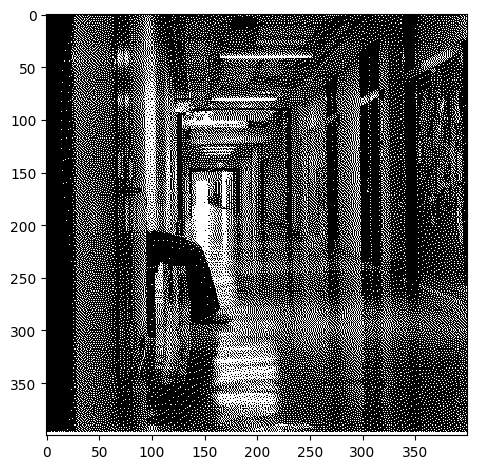

In [14]:
# Reduce unnecessary memory copying (which also invalidates cache)
from numpy import float32

@njit
def dither9(img):
    result = np.empty(img.shape, dtype=np.uint8)
    y_size = img.shape[0]
    x_size = img.shape[1]
    # Allow negative values and wider range; also, the staging arrays have extra entry at start and end
    # so we don't need conditionals in the core loop.
    staging_current = np.zeros(x_size + 2, np.int16)
    staging_current[1:-1] = img[0]
    staging_next = np.zeros(x_size + 2, np.int16)
    
    for y in range(y_size):
        # Copy in next row data:
        if y < y_size - 1:
            staging_next[1:-1] = img[y + 1,:]
        
        for x in range(x_size):
            old_value = staging_current[x + 1]
            new_value = 0 if old_value < 128 else 255
            result[y, x] = new_value  # not going to change anymore
            error = old_value - new_value  # might get negative value
            staging_current[x + 2] += error * 7 // 16
            staging_next[x] += error * 3 // 16
            staging_next[x + 1] += error * 5 // 16
            staging_next[x + 2] += error // 16
        
        # Switch current to next row:
        staging_current, staging_next = staging_next, staging_current

    return result

io.imshow(dither9(image))
%timeit dither9(image)
%timeit dither9(image_large)

934 µs ± 107 ns per loop (mean ± std. dev. of 7 runs, 1,000 loops each)
23.6 ms ± 14.4 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


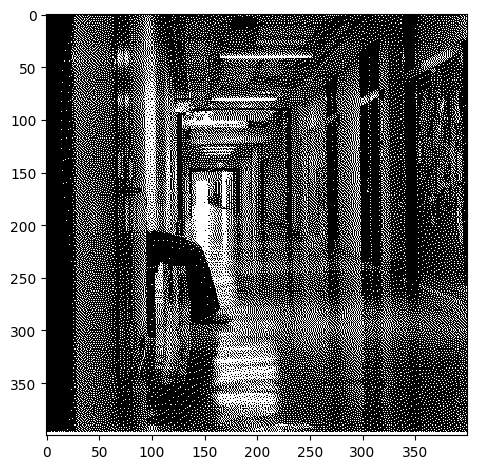

In [24]:
@njit
def dither10(img):
    result = np.empty(img.shape, dtype=np.uint8)
    y_size = img.shape[0]
    x_size = img.shape[1]
    # Allow negative values and wider range; also, the staging arrays have extra entry at start and end
    # so we don't need conditionals in the core loop.
    staging_current = np.zeros(x_size + 2, np.int16)
    staging_current[1:-1] = img[0]
    staging_threes = np.zeros(x_size + 2, np.int16)
    staging_fives = np.zeros(x_size + 2, np.int16)
    staging_ones = np.zeros(x_size + 2, np.int16)
    
    for y in range(y_size):
        for x in range(x_size):
            old_value = staging_current[x + 1]
            new_value = 0 if old_value < 128 else 255
            result[y, x] = new_value  # not going to change anymore
            error = old_value - new_value  # might get negative value
            staging_current[x + 2] += error * 7 // 16
            staging_threes[x] = error
            staging_fives[x + 1] = error
            staging_ones[x + 2] = error
        
        # Copy in next row data:
        if y < y_size - 1:
            #staging_current[1:-1] = img[y + 1,:]
            # Add the errors accumulated from the previous row:
            for i in range(1, x_size + 1):
                staging_current[i] = (
                    img[y + 1, i - 1] +
                    ((3 * staging_threes[i]) // 16) + 
                    ((5 * staging_fives[i]) // 16) +
                    (staging_ones[i] // 16)
                )
            # WHY DOES COMMENTING THIS OUT FIX THE RESULT?
            #staging_threes[:] = 0
            #staging_fives[:] = 0
            #staging_ones[:] = 0

    return result

io.imshow(dither10(image))
%timeit dither10(image)
%timeit dither10(image_large)

160000

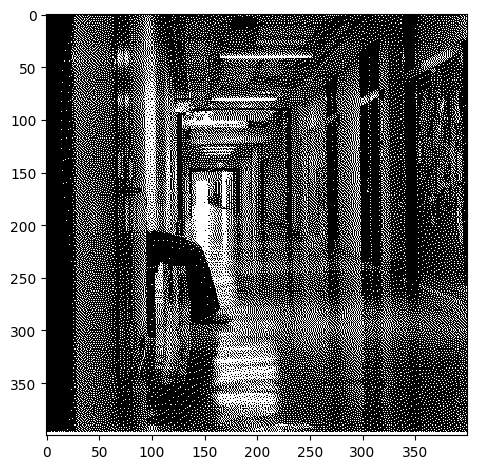

In [12]:
@njit
def dither11(img):
    result = np.empty(img.shape, dtype=np.uint8)
    y_size = img.shape[0]
    x_size = img.shape[1]
    # Allow negative values and wider range; also, the staging arrays have extra entry at start and end
    # so we don't need conditionals in the core loop.
    staging_current = np.zeros(x_size + 2, np.int16)
    staging_current[1:-1] = img[0]
    staging_next = np.zeros(x_size + 2, np.int16)
    
    for y in range(y_size):
        right_pixel_error = 0
        downleft_prev_error = 0
        downleft_prevprev_error = 0
        for x in range(x_size):
            old_value = staging_current[x + 1] + right_pixel_error
            new_value = 0 if old_value < 128 else 255
            result[y, x] = new_value  # not going to change anymore
            error = old_value - new_value  # might get negative value
            right_pixel_error = error * 7 // 16
            # Now that we have all three sets of errors accumulated, store them:
            staging_next[x] = img[y + 1, x - 1] + downleft_prev_error + error * 3 // 16 
            # Accumulate errors for next iteration:
            downleft_prev_error = downleft_prevprev_error + error * 5 // 16
            downleft_prevprev_error = error // 16 
        
        staging_next[x_size] = img[y + 1, x_size - 1] + downleft_prev_error
        
        # Switch current to next row:
        staging_current, staging_next = staging_next, staging_current

    return result

io.imshow(dither11(image))
#%timeit dither11(image)
#%timeit dither11(image_large)
(dither(image) == dither11(image)).sum()